In [2]:
%pip install wfdb numpy pandas matplotlib tensorflow imbalanced-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import wfdb


In [4]:
import os
import wfdb
import numpy as np
import pandas as pd

data = './mitdb1'


patients = [f.split('.')[0] for f in os.listdir(data) if f.endswith('.hea')]
patients = np.sort(patients)
labels_df = pd.DataFrame()

for pat_id in patients:
    file = os.path.join(data, pat_id)
    annotation = wfdb.rdann(file, 'atr')

    #sym is the annotated symbol read from the file
    labels = annotation.symbol

    #values is the different symbols in each patient
    #counts is the number of each symbol for said patient
    vals, cts = np.unique(labels, return_counts=True)

    #df_sub is a mini lil dataframe for each individual patient
    df_per_pat = pd.DataFrame({'Symbol':vals, 'Counts':cts, 'Patient':[pat_id]*len(cts)})
    labels_df = pd.concat([labels_df, df_per_pat],axis = 0)

labels_df.groupby('Symbol').Counts.sum().sort_values(ascending = False)

Symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [5]:
print(np.unique(labels_df.Symbol))
print(len(np.unique(labels_df.Symbol)))

['!' '"' '+' '/' 'A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'S' 'V' '[' ']' 'a' 'e'
 'f' 'j' 'x' '|' '~']
23


In [6]:
# For first stage, consider N as normal heartbeats, all others are irregular or noise (according to found article).
other = ['/','f','j','a']
normal = ['N','L','R','e']
ventricular = ['V','E']
supraventricular = ['S','J','A','a']
fusion = ['F']

#AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]
#classes = [label for sublist in AAMI_labels for label in sublist]

AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]

# Define your classes
classes = ['Normal', 'Ventricular', 'Supraventricular', 'Fusion', 'Other']




In [7]:
def categorize_heartbeat(symbol):

    if symbol in normal:
        return 0

    elif symbol in ventricular:
        return 1

    elif symbol in supraventricular:
        return 2

    elif symbol in fusion:
        return 3

    else:
        return 4

In [8]:
# used to load in the entire ECG dataset,
# get the signal and label,
# read the symbols and signal

def load_ecg(file):

    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    symbol_ann = annotation.symbol
    sample_ann = annotation.sample

    return p_signal, symbol_ann, sample_ann

In [9]:
# creates dataset for model training

def make_dataset(patients, seconds, frequency, classes):

  #set number of data points
  columns = 2 * seconds * frequency
  data_X = np.zeros((1,columns))
  data_Y = np.zeros((1,len(classes)))
  data_Labels = []

  rows_per_patient = []

  for pat in patients:
    file = os.path.join(data, pat)
    p_signal, symbol_ann, sample_ann = load_ecg(file)

    # only using one lead for simplicity
    p_signal = p_signal[:,0]

    # make df without the noise symbols
    df_data = pd.DataFrame({'symbol_ann':symbol_ann, 'sample_ann':sample_ann})
    #df_data = df_data.loc[df_data.symbol_ann.isin(classes)]
    df_data['symbol_ann'] = df_data['symbol_ann'].apply(lambda x: next((class_name for class_name, label_list in zip(classes, AAMI_labels) if x in label_list), 'Other'))



    rows = len(df_data)
    X = np.zeros((rows, columns))
    Y = np.zeros((rows,len(classes)))
    symbs = []

    # keep track of rows
    maximum_rows = 0

    for sample_ann, symbol_ann in zip(df_data.sample_ann.values,df_data.symbol_ann.values):
        left = max([0,(sample_ann - seconds * frequency) ])
        right = min([len(p_signal),(sample_ann + seconds * frequency) ])
        x = p_signal[left: right]
        if len(x) == columns:
            X[maximum_rows,:] = x
            class_index = classes.index(symbol_ann)
            Y[maximum_rows, class_index] = 1
            maximum_rows += 1

    X = X[:maximum_rows,:]
    Y = Y[:maximum_rows,:]

    data_Labels += df_data['symbol_ann'].tolist()
    data_X = np.append(data_X,X,axis = 0)
    data_Y = np.append(data_Y,Y,axis = 0)

  data_X = data_X[1:,:]
  data_Y = data_Y[1:,:]

  return data_X, data_Y, data_Labels

In [10]:
X_data, Y_data, symbol_data = make_dataset(patients, 3, 360, classes)


In [11]:
ydffg = pd.DataFrame(Y_data)

label_counts = ydffg.iloc[:, 0:].sum()
print(label_counts)

0    90098.0
1     7219.0
2     2771.0
3      801.0
4    11344.0
dtype: float64


In [12]:
print((Y_data[1000]))

[1. 0. 0. 0. 0.]


In [13]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
df4 = pd.DataFrame(X_train)

df4

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-0.825,-0.815,-0.805,-0.805,-0.795,-0.785,-0.760,-0.765,-0.740,-0.710,...,-0.520,-0.525,-0.525,-0.530,-0.540,-0.550,-0.550,-0.540,-0.545,-0.535
1,-0.370,-0.370,-0.365,-0.350,-0.335,-0.320,-0.300,-0.265,-0.255,-0.250,...,-0.265,-0.285,-0.300,-0.300,-0.295,-0.270,-0.255,-0.255,-0.250,-0.230
2,-0.225,-0.220,-0.215,-0.220,-0.235,-0.270,-0.270,-0.275,-0.265,-0.250,...,-0.340,-0.330,-0.320,-0.325,-0.335,-0.340,-0.330,-0.325,-0.315,-0.335
3,-0.260,-0.260,-0.270,-0.260,-0.250,-0.255,-0.245,-0.250,-0.255,-0.250,...,-0.375,-0.365,-0.360,-0.345,-0.330,-0.320,-0.310,-0.320,-0.310,-0.325
4,-0.640,-0.645,-0.640,-0.615,-0.600,-0.575,-0.580,-0.585,-0.585,-0.585,...,-0.880,-0.880,-0.885,-0.880,-0.880,-0.875,-0.870,-0.870,-0.880,-0.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78558,0.720,0.705,0.700,0.690,0.675,0.655,0.640,0.605,0.580,0.555,...,-0.670,-0.670,-0.675,-0.660,-0.655,-0.660,-0.675,-0.705,-0.715,-0.725
78559,-0.270,-0.275,-0.270,-0.270,-0.270,-0.255,-0.265,-0.255,-0.245,-0.255,...,-0.055,-0.055,-0.055,-0.040,-0.020,-0.030,-0.035,-0.040,-0.035,-0.040
78560,-0.165,-0.160,-0.175,-0.175,-0.175,-0.175,-0.175,-0.160,-0.170,-0.145,...,0.130,0.145,0.155,0.165,0.180,0.195,0.215,0.230,0.250,0.265
78561,0.100,0.340,0.615,0.870,0.990,0.995,0.835,0.520,0.100,-0.235,...,-0.520,-0.550,-0.535,-0.500,-0.385,-0.250,-0.100,0.080,0.310,0.590


In [15]:
df45 = pd.DataFrame(y_train)

df45

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
78558,0.0,1.0,0.0,0.0,0.0
78559,1.0,0.0,0.0,0.0,0.0
78560,0.0,0.0,0.0,0.0,1.0
78561,1.0,0.0,0.0,0.0,0.0


In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(78563, 2160)
(78563, 5)
(16835, 2160)
(16835, 5)
(16835, 2160)
(16835, 5)


In [18]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


print(X_train_cnn.shape)

(78563, 2160, 1)


In [19]:
print(X_train_cnn.shape)
print(X_train_cnn[0].shape)
samp = X_train_cnn[3]

(78563, 2160, 1)
(2160, 1)


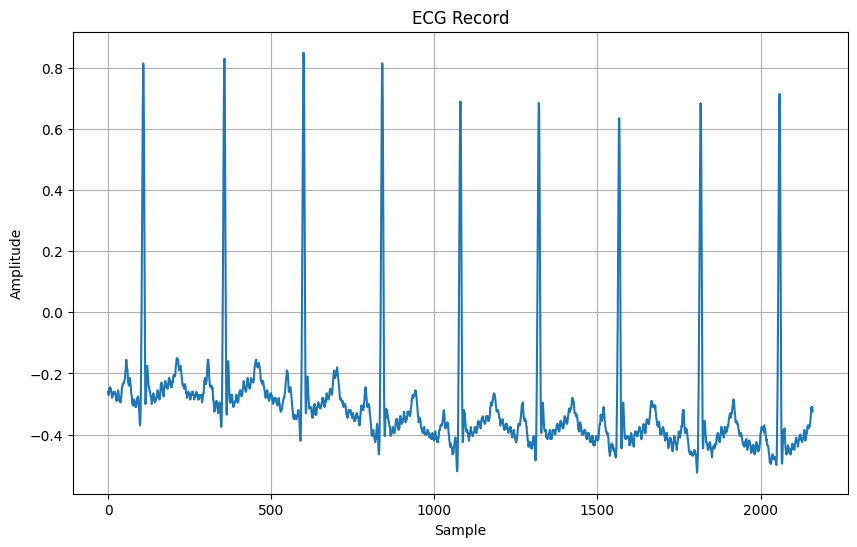

In [20]:
import matplotlib.pyplot as plt






plt.figure(figsize=(10, 6))
plt.plot(samp)
plt.title('ECG Record')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [16]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [16]:
import tensorflow as tf


2024-03-09 22:10:58.640099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 22:11:03.157787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-09 22:11:03.157824: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-09 22:11:12.507230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define a function to build the model
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv1D(hp.Int('conv1_filters', min_value=32, max_value=256, step=32),
                             hp.Int('conv1_kernel', min_value=3, max_value=5, step=1),
                             activation='relu', input_shape=(2160,1)))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(hp.Int('conv2_filters', min_value=64, max_value=512, step=32),
                             hp.Int('conv2_kernel', min_value=3, max_value=5, step=1),
                             activation='relu'))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dense(len(classes), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust this according to your computation resources
    executions_per_trial=1,
    directory='keras_tuner_logs',
    project_name='your_project_name')

# Perform the hyperparameter search
tuner.search(X_train_cnn, y_train, epochs=2, validation_data=(X_valid_cnn, y_valid))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
model.fit(X_train_cnn, y_train, epochs=2, validation_data=(X_valid_cnn, y_valid))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy}")


Trial 5 Complete [00h 14m 38s]
val_accuracy: 0.979447603225708

Best val_accuracy So Far: 0.9804573655128479
Total elapsed time: 02h 31m 43s
Epoch 1/2
2456/2456 [==============================] - 706s 287ms/step - loss: 0.1474 - accuracy: 0.9571 - val_loss: 0.0864 - val_accuracy: 0.9738
Epoch 2/2
527/527 [==============================] - 30s 58ms/step - loss: 0.0856 - accuracy: 0.9763
Test Accuracy: 0.9762994050979614


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(2160,1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(classes), activation='softmax'))  # softmax for multiclass classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train, epochs=2, validation_data=(X_valid_cnn, y_valid))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy}")

2024-03-08 16:37:17.438341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 16:37:17.570217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-08 16:37:17.570243: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-08 16:37:18.279374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Epoch 1/2
2456/2456 [==============================] - 234s 95ms/step - loss: 0.1588 - accuracy: 0.9553 - val_loss: 0.0868 - val_accuracy: 0.9739
Epoch 2/2
527/527 [==============================] - 8s 16ms/step - loss: 0.0902 - accuracy: 0.9759
Test Accuracy: 0.9758836030960083


527/527 [==============================] - 8s 16ms/step


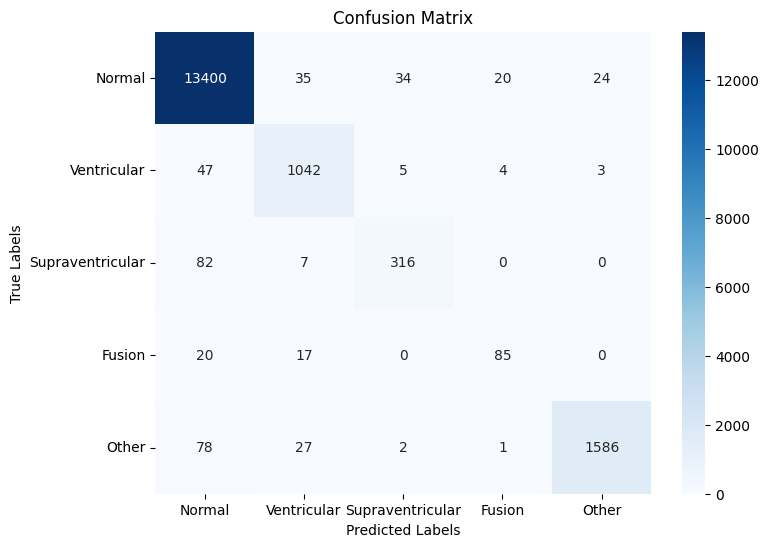

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_valid from one-hot encoded to class labels
y_valid_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid_classes, y_pred_classes)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,  # Replace with your class labels
            yticklabels=classes)  # Replace with your class labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
from sklearn.metrics import classification_report


print(classification_report(y_valid_classes, y_pred_classes, target_names=classes))


                  precision    recall  f1-score   support

          Normal       0.98      0.99      0.99     13513
     Ventricular       0.92      0.95      0.93      1101
Supraventricular       0.89      0.78      0.83       405
          Fusion       0.77      0.70      0.73       122
           Other       0.98      0.94      0.96      1694

        accuracy                           0.98     16835
       macro avg       0.91      0.87      0.89     16835
    weighted avg       0.98      0.98      0.98     16835



In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2158, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1079, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1077, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 538, 128)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 68864)             0         
                                                                 
 dense (Dense)               (None, 128)               8

In [22]:
model.save("./models/MITSmall.keras")


In [ ]:
modelpath = ("./models/")
tf.saved_model.save(model,modelpath )

In [ ]:
modelpath = ("./models/")
tf.saved_model.save(model,modelpath )

converter = tf.lite.TFLiteConverter.from_saved_model('./models/') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [23]:


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('lighter_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpf2sse0mp/assets
2024-03-08 16:48:54.869030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-03-08 16:48:54.869103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-03-08 16:48:54.892545: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf2sse0mp
2024-03-08 16:48:54.894623: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-03-08 16:48:54.894652: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf2sse0mp
2024-03-08 16:48:54.904876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-03-08 16:48:55.531192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


INFO:tensorflow:Assets written to: /tmp/tmpf2sse0mp/assets


In [24]:
interpreter = tf.lite.Interpreter('my_model_2.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



In [25]:
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [   1 2160    1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [58]:
print(samp.shape)
input_data_reshaped = np.expand_dims(samp, axis=0)
print(input_data_reshaped.shape)

(2160, 1)
(1, 2160, 1)


In [62]:


interpreter = tf.lite.Interpreter(model_path='lighter_model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


samp = samp.astype(np.float32)
input_data = samp
interpreter.set_tensor(input_index, input_data_reshaped)
interpreter.invoke()

output = (interpreter.get_tensor(output_index))
predicted_class_index = np.argmax(output)
print(predicted_class_index)


0


In [41]:
print(X_test.shape)
print(y_test.shape)
y_numeric = np.argmax(y_test, axis=1)
print(y_numeric.shape)

(16835, 2160)
(16835, 5)
(16835,)


In [42]:
combined_df = pd.DataFrame(X_test)
combined_df['label'] = y_numeric
combined_df

,0,1,2,3,4,5,6,7,8,9,...,2151,2152,2153,2154,2155,2156,2157,2158,2159,label
0,-0.805,-0.805,-0.810,-0.815,-0.820,-0.825,-0.835,-0.845,-0.860,-0.860,...,0.620,0.790,0.930,1.065,1.195,1.340,1.405,1.360,1.145,2
1,-0.305,-0.305,-0.285,-0.280,-0.280,-0.295,-0.310,-0.305,-0.290,-0.295,...,-0.200,-0.195,-0.215,-0.205,-0.190,-0.160,-0.155,-0.155,-0.150,0
2,-0.215,-0.200,-0.190,-0.180,-0.180,-0.200,-0.215,-0.210,-0.205,-0.185,...,-0.290,-0.285,-0.305,-0.310,-0.310,-0.305,-0.290,-0.290,-0.315,0
3,-1.060,-1.035,-1.030,-1.015,-1.020,-1.020,-1.025,-1.010,-1.020,-1.015,...,-0.995,-1.010,-0.975,-0.955,-0.950,-0.965,-0.965,-0.970,-0.980,0
4,-0.305,-0.325,-0.325,-0.335,-0.310,-0.295,-0.300,-0.300,-0.320,-0.315,...,-0.170,-0.170,-0.170,-0.175,-0.190,-0.220,-0.210,-0.200,-0.200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16830,-0.925,-0.920,-0.905,-0.895,-0.895,-0.885,-0.870,-0.845,-0.815,-0.750,...,0.010,0.070,0.115,0.145,0.160,0.165,0.140,0.090,0.010,0
16831,-0.320,-0.320,-0.320,-0.330,-0.320,-0.350,-0.365,-0.370,-0.365,-0.355,...,-0.195,-0.245,-0.295,-0.310,-0.245,-0.120,0.085,0.345,0.580,0
16832,-0.010,-0.010,0.005,0.005,-0.015,-0.030,-0.045,-0.045,-0.025,-0.030,...,-0.125,-0.140,-0.140,-0.135,-0.120,-0.115,-0.120,-0.135,-0.155,0
16833,-0.355,-0.365,-0.355,-0.330,-0.330,-0.330,-0.340,-0.355,-0.335,-0.305,...,-0.285,-0.285,-0.290,-0.305,-0.300,-0.300,-0.300,-0.280,-0.285,0


In [43]:
# Step 1: Group the combined DataFrame by the label
grouped = combined_df.groupby('label')

# Step 2: Sample 50 rows from each group
sampled_data = []
for label, group in grouped:
    sampled_group = group.sample(n=50, random_state=42)  # Sample 50 rows from each group
    sampled_data.append(sampled_group)

# Step 3: Concatenate the sampled subsets into a balanced prototype set
balanced_prototype_set = pd.concat(sampled_data)

balanced_prototype_set.reset_index(drop=True, inplace=True)



In [44]:
balanced_prototype_set

,0,1,2,3,4,5,6,7,8,9,...,2151,2152,2153,2154,2155,2156,2157,2158,2159,label
0,-0.030,-0.075,-0.115,-0.155,-0.185,-0.195,-0.215,-0.230,-0.245,-0.255,...,-0.260,-0.285,-0.295,-0.270,-0.255,-0.255,-0.260,-0.255,-0.265,0
1,-0.210,-0.225,-0.225,-0.240,-0.250,-0.245,-0.225,-0.230,-0.230,-0.250,...,-0.145,-0.145,-0.145,-0.120,-0.120,-0.125,-0.130,-0.140,-0.145,0
2,0.720,0.750,0.785,0.810,0.860,0.905,0.945,0.965,0.975,0.990,...,0.295,0.390,0.415,0.400,0.345,0.250,0.125,0.015,-0.030,0
3,-0.765,-0.765,-0.755,-0.765,-0.745,-0.725,-0.700,-0.685,-0.695,-0.685,...,-0.615,-0.625,-0.625,-0.615,-0.615,-0.600,-0.580,-0.570,-0.555,0
4,-1.060,-1.055,-1.070,-1.080,-1.050,-1.065,-1.055,-1.045,-1.055,-1.070,...,-0.635,-0.620,-0.625,-0.600,-0.610,-0.585,-0.585,-0.600,-0.600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.275,-0.270,-0.285,-0.290,-0.285,-0.270,-0.260,-0.265,-0.280,-0.275,...,-0.175,-0.160,-0.160,-0.170,-0.175,-0.180,-0.180,-0.170,-0.155,4
246,-0.355,-0.350,-0.355,-0.355,-0.370,-0.360,-0.365,-0.360,-0.350,-0.345,...,0.025,0.020,0.015,-0.005,0.010,0.040,0.040,0.035,-0.010,4
247,-1.395,-1.410,-1.425,-1.440,-1.450,-1.485,-1.495,-1.525,-1.540,-1.545,...,1.700,1.915,2.055,2.100,2.085,2.040,1.955,1.805,1.540,4
248,0.190,0.140,0.140,0.095,0.055,0.005,-0.005,-0.040,-0.055,-0.075,...,-0.285,-0.295,-0.305,-0.325,-0.325,-0.315,-0.305,-0.330,-0.345,4


In [46]:
shuffled_prototype_set = balanced_prototype_set.sample(frac=1, random_state=42)

# Reset the index after shuffling
shuffled_prototype_set.reset_index(drop=True, inplace=True)
shuffled_prototype_set

,0,1,2,3,4,5,6,7,8,9,...,2151,2152,2153,2154,2155,2156,2157,2158,2159,label
0,-0.155,-0.165,-0.175,-0.180,-0.215,-0.205,-0.195,-0.170,-0.165,-0.150,...,-0.450,-0.475,-0.480,-0.490,-0.495,-0.480,-0.470,-0.460,-0.435,2
1,-0.225,-0.235,-0.250,-0.255,-0.255,-0.255,-0.260,-0.260,-0.265,-0.245,...,-0.270,-0.255,-0.230,-0.210,-0.190,-0.175,-0.130,-0.030,0.085,0
2,-0.720,-0.735,-0.765,-0.820,-0.845,-0.835,-0.850,-0.855,-0.875,-0.875,...,-0.445,-0.425,-0.420,-0.420,-0.465,-0.545,-0.610,-0.595,-0.550,1
3,-1.210,-1.190,-1.170,-1.135,-1.120,-1.085,-1.025,-0.975,-0.925,-0.885,...,-1.155,-1.140,-1.105,-1.095,-1.090,-1.090,-1.090,-1.060,-1.025,1
4,0.360,0.345,0.335,0.310,0.260,0.215,0.185,0.165,0.170,0.140,...,-0.230,-0.235,-0.235,-0.225,-0.205,-0.225,-0.215,-0.230,-0.230,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.230,-0.225,-0.235,-0.280,-0.310,-0.350,-0.350,-0.305,-0.260,-0.235,...,-0.120,-0.100,-0.085,-0.070,-0.100,-0.125,-0.115,-0.095,-0.065,2
246,-0.275,-0.285,-0.305,-0.315,-0.310,-0.290,-0.275,-0.270,-0.285,-0.315,...,-0.090,-0.085,-0.085,-0.060,-0.070,-0.095,-0.110,-0.130,-0.115,0
247,-0.930,-0.930,-0.950,-0.960,-0.970,-0.980,-0.995,-0.990,-1.005,-1.045,...,-0.020,-0.010,-0.010,0.000,0.070,0.095,0.090,0.045,-0.015,1
248,-0.270,-0.240,-0.210,-0.200,-0.190,-0.180,-0.195,-0.175,-0.165,-0.160,...,-0.880,-0.845,-0.815,-0.795,-0.785,-0.765,-0.775,-0.745,-0.720,3


In [17]:
print(tf.__version__)


2.11.1
